In [1]:
using Pkg
Pkg.activate("../cheb_bessel_tests-main")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using Plots
using QuadGK
using NPZ
using Interpolations
using DataInterpolations
using LaTeXStrings
using FastChebInterp
using Tullio

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
Precompiling IJuliaExt
  ✓ Plots → FileIOExt
  ✓ Plots → UnitfulExt
  ✓ Plots → IJuliaExt
  3 dependencies successfully precompiled in 39 seconds. 190 already precompiled.
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]
┌ Warning: Module Plots with build ID fafbfcfd-4d42-ce2d-0000-f7c230cd8b9c is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a].
[ Info: Precompiling FileIOExt [f5f51d8f-5827-5d2e-939b-192fcd6ec70c]
┌ Warning: Module Plots with build ID fafbfcfd-4d42-ce2d-0000-f7c230cd8b9c is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base

In [3]:
using Revise
using Blast

Precompiling Blast
  ✓ Blast
  1 dependency successfully precompiled in 13 seconds. 338 already precompiled.
[ Info: Precompiling Blast [aee4e916-1e40-4aff-8d35-b84b50e5d5e3]
┌ Warning: Module FastChebInterp with build ID fafbfcfd-2fe6-8e84-0000-f7d5e43cb47e is missing from the cache.
│ This may mean FastChebInterp [cf66c380-9a80-432c-aff8-4f9c79c0bdde] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing Blast [aee4e916-1e40-4aff-8d35-b84b50e5d5e3].
[ Info: Precompiling UnitfulExt [0e51ec96-f580-5f12-a625-1297083d7970]
┌ Warning: Module Plots with build ID fafbfcfd-4d42-ce2d-0000-f7c230cd8b9c is missing from the cache.
│ This may mean Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1942
[ Info: Skipping precompilation since __precompile__(false). Importing UnitfulExt [0e51ec96-f580-5f12

In [4]:
z_W = npzread("data/mynz.npy")["z"]
W = npzread("data/mynz.npy")["nz"];

In [5]:
pk_lin = npzread("data/camb_lin_pk.npz")["arr_0"]
z_nl = npzread("data/z_nl.npz")["arr_0"]
k_nl = npzread("data/k_nl.npz")["arr_0"];

In [6]:
y = LinRange(log10(first(k_nl)),log10(last(k_nl)), length(k_nl))
x = LinRange(first(z_nl), last(z_nl), length(z_nl))
InterpPmm = Interpolations.interpolate(log10.(pk_lin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, (x, y))
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

In [7]:
pk_nl = npzread("data/camb_nl_pk.npz")["arr_0"];

In [8]:
y = LinRange(log10(first(k_nl)),log10(last(k_nl)), length(k_nl))
x = LinRange(first(z_nl), last(z_nl), length(z_nl))
InterpPmm_nl = Interpolations.interpolate(log10.(pk_nl),BSpline(Cubic(Line(OnGrid()))))
InterpPmm_nl = scale(InterpPmm_nl, (x, y))
InterpPmm_nl = Interpolations.extrapolate(InterpPmm_nl, Line());

In [9]:
z_b = npzread("../cheb_bessel_tests-main/background/z.npy")
χ_b = npzread("../cheb_bessel_tests-main/background/chi.npy")
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ_b, extrapolate=true);

In [10]:
function power_spectrum_limber(ℓ, χ)
    k = (ℓ+0.5) ./ χ
    return @. 10^InterpPmm(z_of_χ(χ),log10(k)) 
end;

function power_spectrum_nl_limber(ℓ, χ)
    k = (ℓ+0.5) ./ χ
    return @. 10^InterpPmm_nl(z_of_χ(χ),log10(k)) 
end;

In [11]:
nχ = 200
χ = LinRange(26, 7000, nχ)

200-element LinRange{Float64, Int64}:
 26.0, 61.0452, 96.0905, 131.136, …, 6894.86, 6929.91, 6964.95, 7000.0

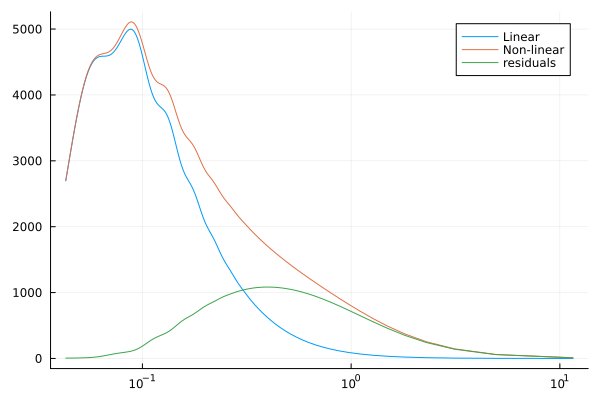

In [12]:
plot((300+0.5) ./ χ, power_spectrum_limber(300., χ),label="Linear", xscale=:log10)
plot!((300+0.5) ./ χ, power_spectrum_nl_limber(300., χ), label="Non-linear")
plot!((300+0.5) ./ χ, power_spectrum_nl_limber(300., χ)-power_spectrum_limber(300., χ), label="residuals")

## Blast set up

In [13]:
cosmo = Blast.FlatΛCDM()

Blast.FlatΛCDM{Float64}(-1.0, 0.0, 67.27, 0.3156, 0.0492, 0.6844, 2.12107e-9, 0.816, 0.0, 0.0, 0.9645)

In [14]:
z_range = z_W
grid = Blast.CosmologicalGrid(z_range=z_range)
bg = Blast.BackgroundQuantities(Hz_array = zeros(length(z_range)), χz_array=zeros(length(z_range))); 

In [15]:
#Evaluate background quantities
Blast.evaluate_background_quantities!(grid, bg, cosmo)

In [16]:
#Building interpolant z(χ), will be useful later
z_of_χ = DataInterpolations.AkimaInterpolation(grid.z_range, bg.χz_array, extrapolate=true);

In [17]:
z_range = z_of_χ.(χ)
grid = Blast.CosmologicalGrid(z_range=z_range)
bg = Blast.BackgroundQuantities(Hz_array = zeros(length(z_range)), χz_array=zeros(length(z_range)) )
Blast.evaluate_background_quantities!(grid, bg, cosmo)

In [18]:
#Define the objects
GK = Blast.GalaxyKernel(1, length(grid.z_range))
SHK = Blast.ShearKernel(1, length(grid.z_range))
CMBK = Blast.CMBLensingKernel(length(grid.z_range));

In [19]:
Blast.compute_kernel!(reshape(W, 1,1000), z_W, GK, ones(1000), grid, bg, cosmo)
Blast.compute_kernel!(reshape(W, 1,1000), z_W, SHK, grid, bg, cosmo)
Blast.compute_kernel!(CMBK, grid, bg, cosmo);

In [20]:
function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.GalaxyKernel, ProbeB::Blast.GalaxyKernel)
    n = length(χ)
    
    F = 1

    Δχ = ((χ[n]-χ[1])/(n-1))
    pesi = Blast.simpson_weight_array(n)

    pk_over_chi = pk ./ (χ .^ 2)

    KA = ProbeA.Kernel
    KB = ProbeB.Kernel

    @tullio Cℓ[i,j] := Δχ*pk_over_chi[m]*KA[i,m]*KB[j,m]*pesi[m]*F
    return Cℓ
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.GalaxyKernel, ProbeB::Blast.ShearKernel)
    n = length(χ)
    
    F = @. sqrt(Blast.factorial_frac(ℓ)) / (ℓ+0.5)^2

    Δχ = ((χ[n]-χ[1])/(n-1))
    pesi = Blast.simpson_weight_array(n)

    pk_over_chi = pk ./ (χ .^ 2)

    KA = ProbeA.Kernel
    KB = ProbeB.Kernel

    @tullio Cℓ[i,j] := Δχ*pk_over_chi[m]*KA[i,m]*KB[j,m]*pesi[m]*F
    return Cℓ
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.ShearKernel, ProbeB::Blast.GalaxyKernel)
    return Cℓ_limber(pk, ℓ, χ, ProbeB, ProbeA)
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.ShearKernel, ProbeB::Blast.ShearKernel)
    n = length(χ)
    
    F = @. Blast.factorial_frac(ℓ) / (ℓ+0.5)^4

    Δχ = ((χ[n]-χ[1])/(n-1))
    pesi = Blast.simpson_weight_array(n)

    pk_over_chi = pk ./ (χ .^ 2)

    KA = ProbeA.Kernel
    KB = ProbeB.Kernel

    @tullio Cℓ[i,j] := Δχ*pk_over_chi[m]*KA[i,m]*KB[j,m]*pesi[m]*F
    return Cℓ
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.ShearKernel, ProbeB::Blast.CMBLensingKernel)
    n = length(χ)
    
    F = @. sqrt(Blast.factorial_frac(ℓ)) * ℓ * (ℓ + 1) / (ℓ+0.5)^4

    Δχ = ((χ[n]-χ[1])/(n-1))
    pesi = Blast.simpson_weight_array(n)

    pk_over_chi = pk ./ (χ .^ 2)

    KA = ProbeA.Kernel
    KB = reshape(ProbeB.Kernel, 1, length(χ))

    @tullio Cℓ[i,j] := Δχ*pk_over_chi[m]*KA[i,m]*KB[j,m]*pesi[m]*F
    return Cℓ
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.CMBLensingKernel, ProbeB::Blast.ShearKernel)
    return Cℓ_limber(pk, ℓ, χ, ProbeB, ProbeA)
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.GalaxyKernel, ProbeB::Blast.CMBLensingKernel)
    n = length(χ)
    
    F = @. ℓ * (ℓ + 1) / (ℓ+0.5)^2

    Δχ = ((χ[n]-χ[1])/(n-1))
    pesi = Blast.simpson_weight_array(n)

    pk_over_chi = pk ./ (χ .^ 2)

    KA = ProbeA.Kernel
    KB = reshape(ProbeB.Kernel, 1, length(χ))

    @tullio Cℓ[i,j] := Δχ*pk_over_chi[m]*KA[i,m]*KB[j,m]*pesi[m]*F
    return Cℓ
end

function Cℓ_limber(pk, ℓ, χ, ProbeA::Blast.CMBLensingKernel, ProbeB::Blast.GalaxyKernel)
    return Cℓ_limber(pk, ℓ, χ, ProbeB, ProbeA)
end

Cℓ_limber (generic function with 8 methods)

In [21]:
Cℓ_gg_lin = zeros(22,1,1)
Cℓ_gs_lin = zeros(22,1,1)
Cℓ_ss_lin = zeros(22,1,1)
Cℓ_gcmbl_lin = zeros(22,1,1)
Cℓ_scmbl_lin = zeros(22,1,1)

Cℓ_gg_nl = zeros(22,1,1)
Cℓ_gs_nl = zeros(22,1,1)
Cℓ_ss_nl = zeros(22,1,1)
Cℓ_gcmbl_nl = zeros(22,1,1)
Cℓ_scmbl_nl = zeros(22,1,1)

@time for (lindex, ell) in enumerate(Blast.ℓ)
    println("Processing ℓ=$(ell)")
    Cℓ_gg_lin[lindex,1,1] = Cℓ_limber(power_spectrum_limber(ell, χ), ell, χ, GK, GK)[1]
    Cℓ_gs_lin[lindex,1,1] = Cℓ_limber(power_spectrum_limber(ell, χ), ell, χ, GK, SHK)[1]
    Cℓ_ss_lin[lindex,1,1] = Cℓ_limber(power_spectrum_limber(ell, χ), ell, χ, SHK, SHK)[1]
    Cℓ_gcmbl_lin[lindex,1,1] = Cℓ_limber(power_spectrum_limber(ell, χ), ell, χ, GK, CMBK)[1]
    Cℓ_scmbl_lin[lindex,1,1] = Cℓ_limber(power_spectrum_limber(ell, χ), ell, χ, SHK, CMBK)[1]
    Cℓ_gg_nl[lindex,1,1] = Cℓ_limber(power_spectrum_nl_limber(ell, χ), ell, χ, GK, GK)[1]
    Cℓ_gs_nl[lindex,1,1] = Cℓ_limber(power_spectrum_nl_limber(ell, χ), ell, χ, GK, SHK)[1]
    Cℓ_ss_nl[lindex,1,1] = Cℓ_limber(power_spectrum_nl_limber(ell, χ), ell, χ, SHK, SHK)[1]
    Cℓ_gcmbl_nl[lindex,1,1] = Cℓ_limber(power_spectrum_nl_limber(ell, χ), ell, χ, GK, CMBK)[1]
    Cℓ_scmbl_nl[lindex,1,1] = Cℓ_limber(power_spectrum_nl_limber(ell, χ), ell, χ, SHK, CMBK)[1]
end

Processing ℓ=2.0
Processing ℓ=2.492946194634132
Processing ℓ=3.971298300156713
Processing ℓ=6.433597361523084
Processing ℓ=9.877413386836713
Processing ℓ=14.299347745457478
Processing ℓ=19.695036522039967
Processing ℓ=26.059154823191424
Processing ℓ=33.385422032497665
Processing ℓ=41.66660800873399
Processing ℓ=50.894540221141625
Processing ℓ=61.06011181472877
Processing ℓ=72.15329059763691
Processing ℓ=84.16312894170306
Processing ℓ=97.07777458644667
Processing ℓ=110.88448233582058
Processing ℓ=125.56962663618027
Processing ℓ=141.1187150230602
Processing ℓ=157.51640242348716
Processing ℓ=174.74650629971285
Processing ℓ=192.7920226194276
Processing ℓ=211.6351426366853
  1.071676 seconds (4.05 M allocations: 251.087 MiB, 1.28% gc time, 99.50% compilation time)


In [22]:
blast_gg = npzread("blast_cls/blast_gg.npy")
blast_ss = npzread("blast_cls/blast_ss.npy")
blast_gs = npzread("blast_cls/blast_gs.npy")
blast_gcmbl = npzread("blast_cls/blast_gcmbl.npy")
blast_scmbl = npzread("blast_cls/blast_scmbl.npy");

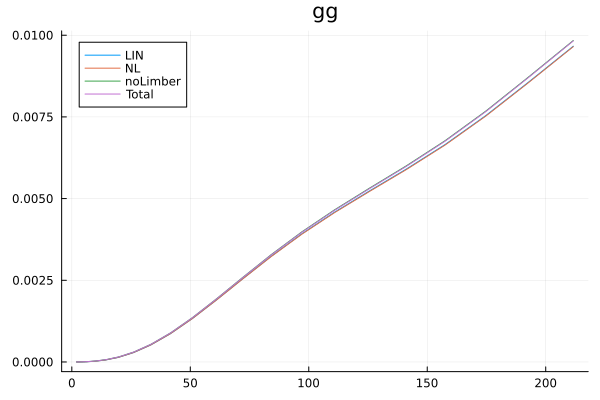

In [23]:
plot(Blast.ℓ, Cℓ_gg_lin[:,1,1] .*Blast.ℓ .*(Blast.ℓ .+1), label="LIN", title = "gg")
plot!(Blast.ℓ, Cℓ_gg_nl[:,1,1] .*Blast.ℓ .*(Blast.ℓ .+1), label="NL")
plot!(Blast.ℓ, blast_gg, label="noLimber")
plot!(Blast.ℓ, blast_gg + (Cℓ_gg_nl[:,1,1]-Cℓ_gg_lin[:,1,1]) .*Blast.ℓ .*(Blast.ℓ .+1) , label="Total" )

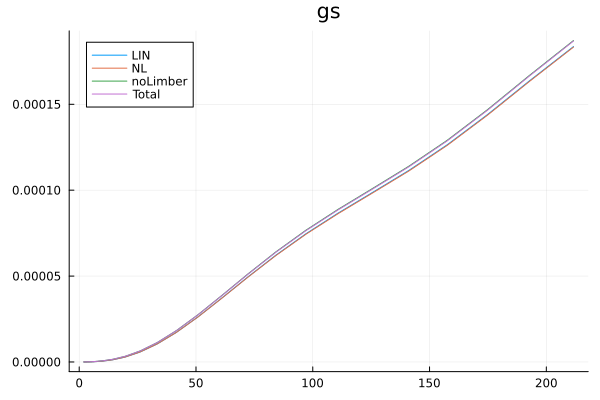

In [24]:
plot(Blast.ℓ, Cℓ_gs_lin[:,1,1] .*Blast.ℓ .*(Blast.ℓ .+1), label="LIN", title="gs")
plot!(Blast.ℓ, Cℓ_gs_nl[:,1,1] .*Blast.ℓ .*(Blast.ℓ .+1), label="NL")
plot!(Blast.ℓ, blast_gs, label="noLimber")
plot!(Blast.ℓ, blast_gs + (Cℓ_gs_nl[:,1,1]-Cℓ_gs_lin[:,1,1]) .*Blast.ℓ .*(Blast.ℓ .+1) , label="Total" )

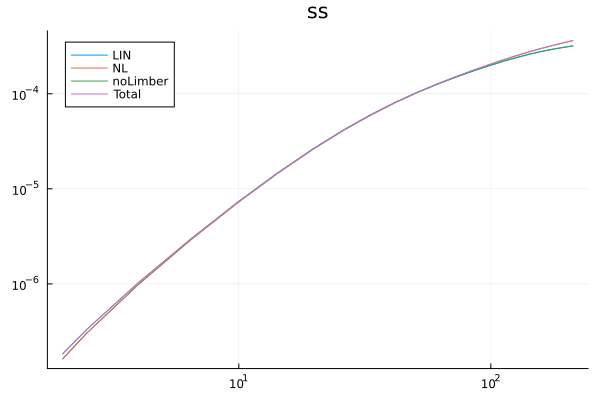

In [25]:
plot(Blast.ℓ, Cℓ_ss_lin[:,1,1] .*Blast.ℓ .*(Blast.ℓ .+1), label="LIN",xscale=:log10, yscale=:log10, title="ss")
plot!(Blast.ℓ, Cℓ_ss_nl[:,1,1] .*Blast.ℓ .*(Blast.ℓ .+1), label="NL")
plot!(Blast.ℓ, blast_ss, label="noLimber")
plot!(Blast.ℓ, blast_ss + (Cℓ_ss_nl[:,1,1]-Cℓ_ss_lin[:,1,1]) .*Blast.ℓ .*(Blast.ℓ .+1) , label="Total" )

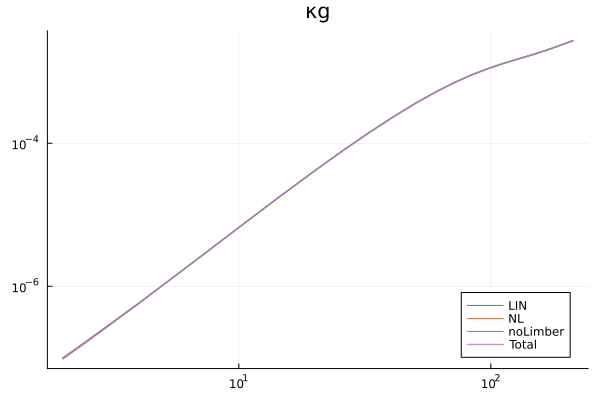

In [26]:
plot(Blast.ℓ, Cℓ_gcmbl_lin[:,1,1] .*Blast.ℓ .*(Blast.ℓ .+1), label="LIN", title ="κg", xscale=:log10, yscale=:log10, legend=:bottomright)
plot!(Blast.ℓ, Cℓ_gcmbl_nl[:,1,1] .*Blast.ℓ .*(Blast.ℓ .+1), label="NL")
plot!(Blast.ℓ, blast_gcmbl, label="noLimber")
plot!(Blast.ℓ, blast_gcmbl + (Cℓ_gcmbl_nl[:,1,1]-Cℓ_gcmbl_lin[:,1,1]) .*Blast.ℓ .*(Blast.ℓ .+1) , label="Total" )

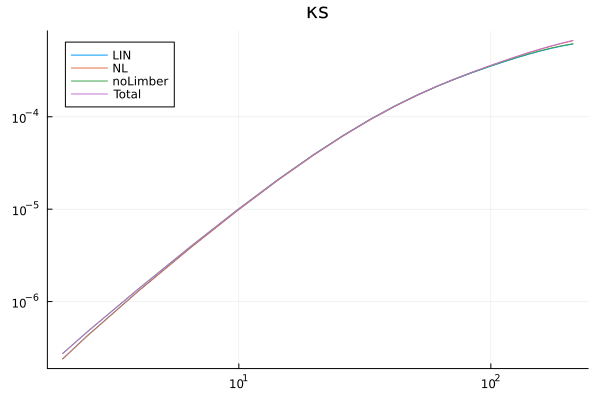

In [27]:
plot(Blast.ℓ, Cℓ_scmbl_lin[:,1,1] .*Blast.ℓ .*(Blast.ℓ .+1), label="LIN", title="κs",xscale=:log10, yscale=:log10)
plot!(Blast.ℓ, Cℓ_scmbl_nl[:,1,1] .*Blast.ℓ .*(Blast.ℓ .+1), label="NL")
plot!(Blast.ℓ, blast_scmbl, label="noLimber")
plot!(Blast.ℓ, blast_scmbl + (Cℓ_scmbl_nl[:,1,1]-Cℓ_scmbl_lin[:,1,1]) .*Blast.ℓ .*(Blast.ℓ .+1) , label="Total" )

In [28]:
final_Dℓ_gg = blast_gg + (Cℓ_gg_nl[:,1,1]-Cℓ_gg_lin[:,1,1]) .*Blast.ℓ .*(Blast.ℓ .+1)
final_Dℓ_gs = blast_gs + (Cℓ_gs_nl[:,1,1]-Cℓ_gs_lin[:,1,1]) .*Blast.ℓ .*(Blast.ℓ .+1)
final_Dℓ_ss = blast_ss + (Cℓ_ss_nl[:,1,1]-Cℓ_ss_lin[:,1,1]) .*Blast.ℓ .*(Blast.ℓ .+1)
final_Dℓ_gcmbl = blast_gcmbl + (Cℓ_gcmbl_nl[:,1,1]-Cℓ_gcmbl_lin[:,1,1]) .*Blast.ℓ .*(Blast.ℓ .+1)
final_Dℓ_scmbl = blast_scmbl + (Cℓ_scmbl_nl[:,1,1]-Cℓ_scmbl_lin[:,1,1]) .*Blast.ℓ .*(Blast.ℓ .+1);

In [29]:
npzwrite("blast_cls/D_gg.npy", final_Dℓ_gg)
npzwrite("blast_cls/D_gs.npy", final_Dℓ_gs)
npzwrite("blast_cls/D_ss.npy", final_Dℓ_ss)
npzwrite("blast_cls/D_gcmbl.npy", final_Dℓ_gcmbl)
npzwrite("blast_cls/D_scmbl.npy", final_Dℓ_scmbl)

In [30]:
npzwrite("blast_cls/blast_gg_lin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_gg_lin[:,1,1])
npzwrite("blast_cls/blast_ss_lin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_ss_lin[:,1,1])
npzwrite("blast_cls/blast_gs_lin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_gs_lin[:,1,1])
npzwrite("blast_cls/blast_gcmbl_lin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_gcmbl_lin[:,1,1])
npzwrite("blast_cls/blast_scmbl_lin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_scmbl_lin[:,1,1])

In [31]:
npzwrite("blast_cls/blast_gg_nonlin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_gg_nl[:,1,1])
npzwrite("blast_cls/blast_ss_nonlin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_ss_nl[:,1,1])
npzwrite("blast_cls/blast_gs_nonlin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_gs_nl[:,1,1])
npzwrite("blast_cls/blast_gcmbl_nonlin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_gcmbl_nl[:,1,1])
npzwrite("blast_cls/blast_scmbl_nonlin.npy", Blast.ℓ .* (Blast.ℓ .+ 1) .* Cℓ_scmbl_nl[:,1,1])

# Limber non-linear correction for brute force integral

In [32]:
brute_ell = [2., 5., 10., 50., 100., 150., 200.]
res_gg = zeros(7,1,1)
res_gs = zeros(7,1,1)
res_ss = zeros(7,1,1)
res_gk = zeros(7,1,1)
res_sk = zeros(7,1,1)


@time for (lindex, ell) in enumerate(brute_ell)
    println("Processing ℓ=$(ell)")
    res_gg[lindex,1,1] = Cℓ_limber(power_spectrum_nl_limber(ell, χ) .- power_spectrum_limber(ell, χ), ell, χ, GK, GK)[1]
    res_gs[lindex,1,1] = Cℓ_limber(power_spectrum_nl_limber(ell, χ) .- power_spectrum_limber(ell, χ), ell, χ, GK, SHK)[1]
    res_ss[lindex,1,1] = Cℓ_limber(power_spectrum_nl_limber(ell, χ) .- power_spectrum_limber(ell, χ), ell, χ, SHK, SHK)[1]
    res_gk[lindex,1,1] = Cℓ_limber(power_spectrum_nl_limber(ell, χ) .- power_spectrum_limber(ell, χ), ell, χ, GK, CMBK)[1]
    res_sk[lindex,1,1] = Cℓ_limber(power_spectrum_nl_limber(ell, χ) .- power_spectrum_limber(ell, χ), ell, χ, SHK, CMBK)[1]
end

Processing ℓ=2.0
Processing ℓ=5.0
Processing ℓ=10.0
Processing ℓ=50.0
Processing ℓ=100.0
Processing ℓ=150.0
Processing ℓ=200.0
  0.017959 seconds (2.50 k allocations: 616.945 KiB, 91.29% compilation time)


In [33]:
npzwrite("brute_force/res_gg.npy", res_gg[:,1,1])
npzwrite("brute_force/res_ss.npy", res_ss[:,1,1])
npzwrite("brute_force/res_gs.npy", res_gs[:,1,1])
npzwrite("brute_force/res_gk.npy", res_gk[:,1,1])
npzwrite("brute_force/res_sk.npy", res_sk[:,1,1])